# 2025 ASAP CRN Colloborative Meeting - CRN Cloud Training Workshop Notebooks

## Overview
This notebook demonstrates how to use the Verily Workbench JupyterLab apps to explore and analyze ASAP CRN Cloud data.   The the harmonized cohort of PMDBS scRNAseq datasets will be used to illustrate the example.   

The notebook below is organized into 4 parts.  

1. The _basics_ of "Exploratory Data Analysis" (EDA) 
2. Data Composition to create a smaller (more wieldy) _sub_- dataset 
3. Gene of Interest (GOI) Analysis , which constitutes the bulk of the workshop's activities

and finally, 

4. An _advanced_ Differential Expression (DE) Analysis 


This notebook contains the entire set of materials as a reference.  For the workshop, the first two parts will be scrolled through (but not executed) for speed.  The workshop activities themselves are contained in Parts 3 and 4.  The intermediate data files will be provided to enable skipping ahead. 


## Outline 
1. [ASAP CRN Cloud __Basics__](#part-1-asap-crn-cloud-basics)
    * Browse ASAP CRN curated datasets and collections on a cloud environment
    * Define paths to dataset 
        * cell-wise data metrics (_cell_ metadata)
        * gene expression data (anndata objects)
        * _dataset_ metadata
    * Load _cell_-metadata and visualize
        * basic QC visualizations
        * UMAP visualizations
    * Load _processed_ `AnnData` object 
        * access gene expression 
        * UMAP visualizations
        * Load _dataset_ metadata
            * merge _dataset_ metadata with _cell_ metadata
            * create Case-Control and Brain Region sub-sets


2. [`AnnData` Data Composition](#part-2-anndata-data-composition)
    * Load unfiltered dataset `AnnData` object
    * combine with _processed_ artifacts (`adata.obs`) 
    * Subset to a single brain region and Case-Contol group (from _dataset_ metadata)
        * annotate cell metadata with dataset metadata
        * save full gene expression `anndata` for subset with full metadata annotation (_dataset_ and _cell_-level)

3. [Gene of Interest Analysis (__Workshop__)](#part-3-gene-of-interest-analysis-workshop)
    * Choose Parkinson's Disease relavent gene
    * visualize specific gene expression

    
4. [Differential Expression (DE) Analysis (__Take Home__)](#part-4-differential-expression-de-analysis-advanced)
    * Differential expression analysis,
        * psuedobulk over 'sample' and 'cell_type' 
        * logistic regression CASE vs. CONTROL
    * Differential expression analysis meta-analysis
        * psuedobulk over 'sample' and 'cell_type' 
        * logistic regression CASE vs. CONTROL per source dataset
        * statistical meta analysis to verify consistency across Datasets / Teams




## Notebooks
All of this content can be found in shorter more specific notebooks.  E.g. During the workshop you can follow along for Parts 1 & 2, but should start with Part 3 ([03_GOI_analysis.ipynb](./03_GOI_analysis.ipynb))

- This notebook [00_full_example_notebook.ipynb](./00_full_example_notebook.ipynb)
    - Part 1 - [01_basic_EDA.ipynb](./01_basic_EDA.ipynb)  
    - Part 2 - [02_dataset_composition.ipynb](./02_dataset_composition.ipynb)
    - Part 3 - [03_GOI_analysis.ipynb](./03_GOI_analysis.ipynb)
    - Part 4 - [04_DE_analysis.ipynb](./04_DE_analysis.ipynb)



------------------------------
>> NOTES
>>   need to test that this runs reasonably fast on a generic VM
>>   need to develop an equivalent R version

## Imports

In [1]:
import numpy as np
import pandas as pd
import logging
import warnings

# Use pathlib for file path manipulation
from pathlib import Path 


# matplotlib and seaborn a pythonic alternative to plotnine
try:
    import seaborn as sns
    import matplotlib.pyplot as plt
except ImportError as e:
    print("Error -> ", e)
    print("Installing seaborn or matplotlib")
    !pip install matplotlib seaborn
    import seaborn as sns
    import matplotlib.pyplot as plt


    
#  plotnine: a ggplot2-compatible Python plotting package
try:
    import plotnine as p9
except ImportError as e:
    print("Error -> ", e)
    print("Installing plotnine")
    !pip install plotnine
    import plotnine as p9

try:
    import scanpy as sc
except ImportError as e:
    print("Error -> ", e)
    print("Installing scanpy")
    !pip install scanpy
    import scanpy as sc


try:
    from scipy.stats import norm
    import statsmodels.formula.api as smf    
    from statsmodels.stats.multitest import multipletests

except ImportError as e:
    print("Error -> ", e)
    print("Installing scipy and statsmodel")
    !pip install scanpy statsmodel
    from scipy.stats import norm
    import statsmodels.formula.api as smf    
    from statsmodels.stats.multitest import multipletests

try:
    %load_ext autotime
except:
    !pip install ipython-autotime
    %load_ext autotime

# Always show all columns in a Pandas DataFrame
pd.set_option('display.max_columns', None)

time: 122 μs (started: 2025-03-05 20:59:42 -08:00)


-------------------



# Part 1: ASAP CRN Cloud __Basics__



## Browse ASAP CRN datasets and collections

ASAP CRN data availabe in Google Cloud Storage as files and is included as referenced resources in this workspace. The cloud storage buckets automatically mount onto newly created cloud environments. Read more about bucket automounting [here](https://support.workbench.verily.com/docs/how_to_guides/workspace_file_mount/#bucket-automounting)

1. Navigate to the `workspace` folder in the file browser on the left: 

![image.png](./workspace_example1.png)

2. If you don't see this folder, run the `wb resource mount` command in the cell below

3. Navigate through the `01_PMDBS_scRNAseq_Datasets`,`02_PMDBS_bulkRNAseq_Datasets`,`03_Other_PMDBS_Datasets`, `Documentation`, and `Sample_Notebooks` to browse the available data and resources



###  ASAP CRN data paths
First, let's build the paths to our data. 

In [2]:
# Workspace Path
HOME_PATH = Path.home()
WS_PATH =  HOME_PATH / "workspace"
if not WS_PATH.exists():
    print(f"{WS_PATH} doesn't exist. We need to remount our resources")
    !wb resource mount    

time: 1.08 ms (started: 2025-03-05 20:59:43 -08:00)


We'll focus in on the datasets processed with our *PMDBS scRNAseq* workflow.  Specifically the _cohort_ dataset: `asap-cohort-pmdbs-sc-rnaseq`.  This dataset includes samples from 5 Contributing datasets which have been processesed and integrated.  The paths include the following parts.

- `workflow` designates the workflow which performs the aggregation and integration.  In this case the [*PMDBS scRNAseq* workflow](https://github.com/ASAP-CRN/pmdbs-sc-rnaseq-wf)
- `dataset_team` designates the contributing team for the dataset.  In this case _cohort_ designates that it is made from multiple individual contributed datasets.
- `source` designates the _source_ of the samples.  In this case Post-mortem derived Brain samples
- `dataset_type` designates the 
- `bucket_name` designates the datasets gcp bucket
- `dataset_name` designates the unique designation for each dataset or collection

In [3]:
DATASETS_PATH = WS_PATH / "01_PMDBS_scRNAseq_Datasets"
workflow = "pmdbs_sc_rnaseq"
dataset_team = "cohort"
dataset_source = "pmdbs"
dataset_type = "sc-rnaseq"
bucket_name = f"asap-curated-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_name = f"asap-{dataset_team}-{dataset_source}-{dataset_type}"
dataset_path = DATASETS_PATH / bucket_name / workflow

time: 1.42 ms (started: 2025-03-05 20:59:44 -08:00)


#### Cohort Analysis Path

Now that we've defined the path to our cohort dataset, lets list the curated files for the `cohort_analysis`.   

In [4]:
cohort_analysis_path = dataset_path / "cohort_analysis"

time: 158 μs (started: 2025-03-05 20:59:45 -08:00)


In [5]:
!ls  {cohort_analysis_path} # pythonic way: # [f.name for f in cohort_analysis_path.glob("**/*") if f.is_file()]

asap-cohort.all_genes.csv
asap-cohort.cell_types.csv
asap-cohort.doublet_score.violin.png
asap-cohort.features.umap.png
asap-cohort.final_adata.h5ad
asap-cohort.final_metadata.csv
asap-cohort.final_validation_metrics.csv
asap-cohort.groups.umap.png
asap-cohort.hvg_genes.csv
asap-cohort.initial_metadata.csv
asap-cohort.merged_adata_object.h5ad
asap-cohort.n_genes_by_counts.violin.png
asap-cohort.pct_counts_mt.violin.png
asap-cohort.pct_counts_rb.violin.png
asap-cohort.sample_list.tsv
asap-cohort_scvi_model.tar.gz
asap-cohort.total_counts.violin.png
MANIFEST.tsv
pmdbs_sc_rnaseq_cohort_analysis_team-scherzer.merged_adata_object.h5ad
time: 196 ms (started: 2025-03-05 20:59:46 -08:00)


#### Dataset Metadata Path

The dataset metadata can be found in the `release_resources`.  Note that the metadata are organized by the _short_ `dataset_name` rather than `bucket_name`.  



In [6]:
ds_metadata_path = WS_PATH / 'release_resources/asap-crn-cloud-release-resources' / dataset_name / "metadata"

!ls {ds_metadata_path} 


ASSAY_RNAseq.csv  CONDITION.csv  PMDBS.csv     SAMPLE.csv  SUBJECT.csv	v2.0.0
CLINPATH.csv	  DATA.csv	 PROTOCOL.csv  STUDY.csv   v1.0.0
time: 193 ms (started: 2025-03-05 20:59:47 -08:00)


#### Workshop/Notebook Artifact Path

This is the path to where the artifacts we've created in these notebooks can be found in case you want to skip ahead.  Particularly for the workshop.  In which case you can replace the `local_data_path` with `WORKSHOP_PATH`.

In [7]:
WORKSHOP_PATH = WS_PATH / "release_resources/asap-crn-cloud-release-resources/release-artifacts/2025_CRN_CM_Workshop_Resources_03122025" 

!ls {WORKSHOP_PATH}


00_ful_example_notebook.ipynb  03_GOI_analysis.ipynb	workspace_example1.png
01_basic_EDA.ipynb	       03-R_GOI_analysis.ipynb
02_dataset_composition.ipynb   04_DE_analysis.ipynb
time: 194 ms (started: 2025-03-05 20:59:49 -08:00)


#### Local Data Path
Lets also define a path for copying our data files and exporting intermediate analysis artifacts to your workspace.  In this example we'll make a "workshop_files" in the "ws_files" which are persistent in our Verily Workbench Workspace. 

In [8]:
local_data_path = WS_PATH / "workshop_files"

if not local_data_path.exists():
    local_data_path.mkdir(parents=True)

time: 285 μs (started: 2025-03-05 20:59:51 -08:00)


In [10]:
### TODO: complete the CODE HERE

workshop_resources_path = WS_PATH / 'release_resources/asap-crn-cloud-release-resources/release-artifacts/2025_CRN_CM_Workshop_Resources_03122025' 

!cp -r {workshop_resources_path} {local_data_path}

## workshop data
# 'workshop/asap-cohort.frontal_ctx_case_control_samples.h5ad'
# 'workshop/asap-cohort.full_frontal_ctx_case_control_samples.h5ad'
# 'workshop/asap-cohort.asap-cohort-dataset-metadata.csv
# "workshop/merged_adata_object.h5ad"

# # make sure we have all the files we need:
# - 'workspace/01_PMDBS_scRNAseq_Datasets/asap-curated-cohort-pmdbs-sc-rnaseq/pmdbs_sc_rnaseq/cohort_analysis/asap-cohort.final_metadata.csv'
# - 'workspace/01_PMDBS_scRNAseq_Datasets/asap-curated-cohort-pmdbs-sc-rnaseq/pmdbs_sc_rnaseq/cohort_analysis/asap-cohort.final_adata.h5ad'
# - 'workspace/01_PMDBS_scRNAseq_Datasets/asap-curated-cohort-pmdbs-sc-rnaseq/pmdbs_sc_rnaseq/cohort_analysis/asap-cohort.merged_adata_object.h5ad'

# psuedobulk data


cp: cannot stat '/home/ergonyc/workspace/release_resources/asap-crn-cloud-release-resources/release-artifacts/2025_CRN_CM_Workshop_Resources_03122025': No such file or directory
time: 187 ms (started: 2025-03-05 21:01:03 -08:00)


## Load _cell_-metadata for Visualization

Full metadata for the releases CDE schema version are in the 'metadata/' subdirectory.   A summary of raw and curated files for the dataset are also available.  The _dataset metadata_ contains the information about the context and provenance of the samples contributing to the dataset, such as Clinical Pathology status of the donor, the fastq file names, and assay information. The tables are either dataset-level, subject-level, or sample-level.  This is distinguished from the _cell metadata_ below which captures metrics and observation metadata of the gene expression measurements which are cell-level metadata.  (I.e. each row represents a single cell observation). 


In [11]:
cell_metadata_filename = local_data_path / f"asap-{dataset_team}.final_metadata.csv"

time: 180 μs (started: 2025-03-05 21:02:10 -08:00)


In [12]:
# copy the files to the local_data_path
if not cell_metadata_filename.exists():
    cell_metadata_filename_og = cohort_analysis_path / f"asap-{dataset_team}.final_metadata.csv"
    !cp {cell_metadata_filename_og} {cell_metadata_filename}


time: 1.06 s (started: 2025-03-05 21:02:12 -08:00)


In [13]:
# load the adata object

cell_metadata_df = pd.read_csv(cell_metadata_filename, low_memory=False)
print(f"We have loaded the cell_metadata for N={cell_metadata_df.shape[0]} cells")

We have loaded the cell_metadata for N=2796736 cells
time: 7.14 s (started: 2025-03-05 21:02:14 -08:00)


## Visualize ASAP CRN Data

We'll use [plotnine](https://plotnine.readthedocs.io/en/v0.12.3/) to visualize ASAP CRN Data.  `plotnine` is a Python implementation of [`ggplot2`](https://ggplot2.tidyverse.org/), the R tidyverse plotting package.  Its syntax is practically identical to `ggplot2`.  Later we'll load the `anndata` summary counts data objects, but for now we'll just look at the cell-wise metadata.

This dataframe is simply the `obs` field from the curated `anndata` object, but provides a smaller footprint entry point into exploring the data.   The dataframe summarizes each cell's (unique 'barcode') _observations_:  QC metrics (CellBender 'cell_probability', 'n_genes_by_counts', 'total_counts', etc), references to the dataset metadata ('sample','batch','team','dataset', etc.), and _downstream_ analysis values ('UMAP_1','UMAP_2', CellAssign 'cell_type', leiden cluster designations, etc.)

### Basic QC

First lets see what kind of metadata is available.

In [14]:
cell_metadata_df.columns.to_list()

['barcode',
 'background_fraction',
 'cell_probability',
 'cell_size',
 'droplet_efficiency',
 'n_genes_by_counts',
 'total_counts',
 'total_counts_rb',
 'pct_counts_rb',
 'total_counts_mt',
 'pct_counts_mt',
 'doublet_score',
 'sample',
 'batch',
 'team',
 'dataset',
 'batch_id',
 'S_score',
 'G2M_score',
 'phase',
 '_scvi_batch',
 '_scvi_labels',
 'leiden_res_0.05',
 'leiden_res_0.10',
 'leiden_res_0.20',
 'leiden_res_0.40',
 'cell_type',
 'UMAP_1',
 'UMAP_2']

time: 1.18 ms (started: 2025-03-05 21:02:22 -08:00)


For instance we can see that CellAssign over these 2.8m cells infers mostly Excitatory Neurons, and Inhibitory Neurons are probably under-represented. (In the future cell-types will be inferred by leveraging a Whole Human Brain atlas via the Allen Brain Cell's MapMyCells.)

In [15]:
cell_metadata_df["cell_type"].value_counts()

cell_type
ExN      1210484
OPC       922838
Oligo     363465
Astro     183842
MG         75153
VC         36770
InN         4184
Name: count, dtype: int64

time: 60.4 ms (started: 2025-03-05 21:02:22 -08:00)


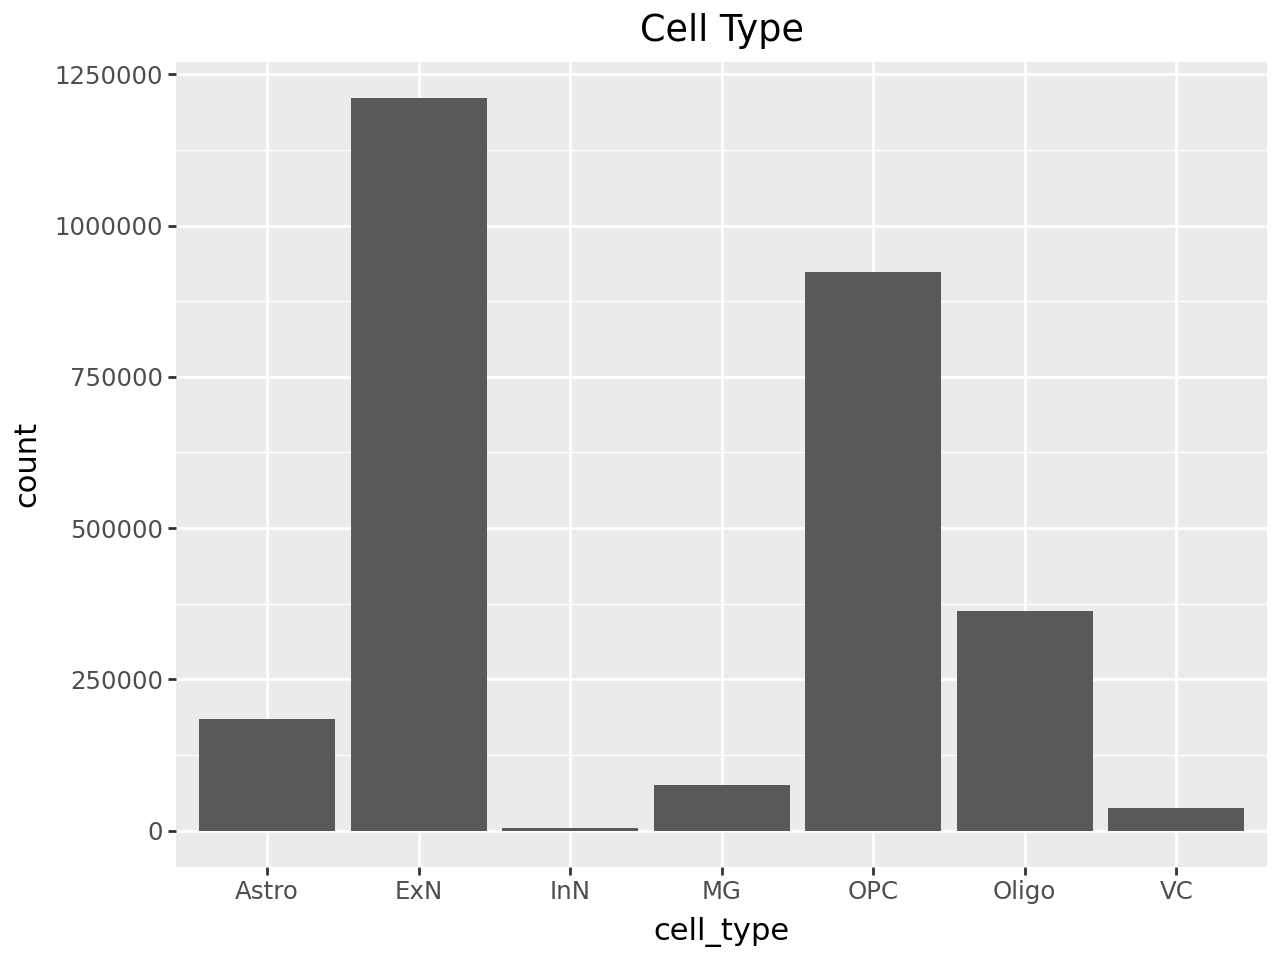

time: 6.11 s (started: 2025-03-05 21:02:23 -08:00)


In [16]:
# Cell type counts
(
    p9.ggplot(cell_metadata_df, p9.aes("cell_type"))
    + p9.geom_bar()
    + p9.ggtitle("Cell Type")
).show()

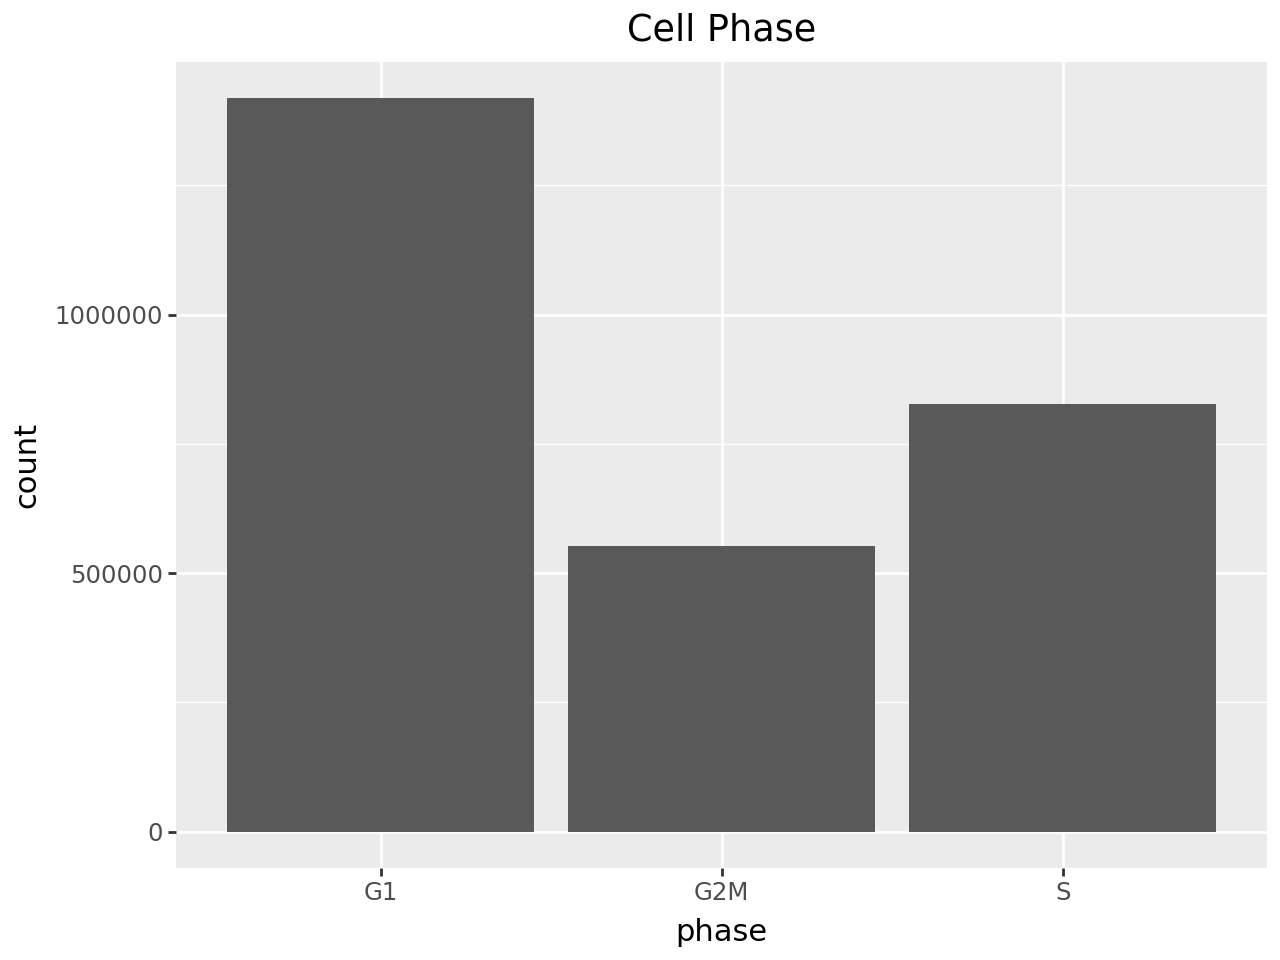

time: 5.99 s (started: 2025-03-05 21:02:29 -08:00)


In [17]:
# Cell phase counts
(
    p9.ggplot(cell_metadata_df, p9.aes("phase"))
    + p9.geom_bar()
    + p9.ggtitle("Cell Phase")
).show()

We can create 'n_genes_by_counts' vs 'total_counts' scatter plots, colored by cell type using [matplotlib](https://matplotlib.org/) via [pandas](https://pandas.pydata.org/)


Let's plot histograms of `n_genes_by_counts` and `counts`.

/tmp/ipykernel_1356486/1942180489.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


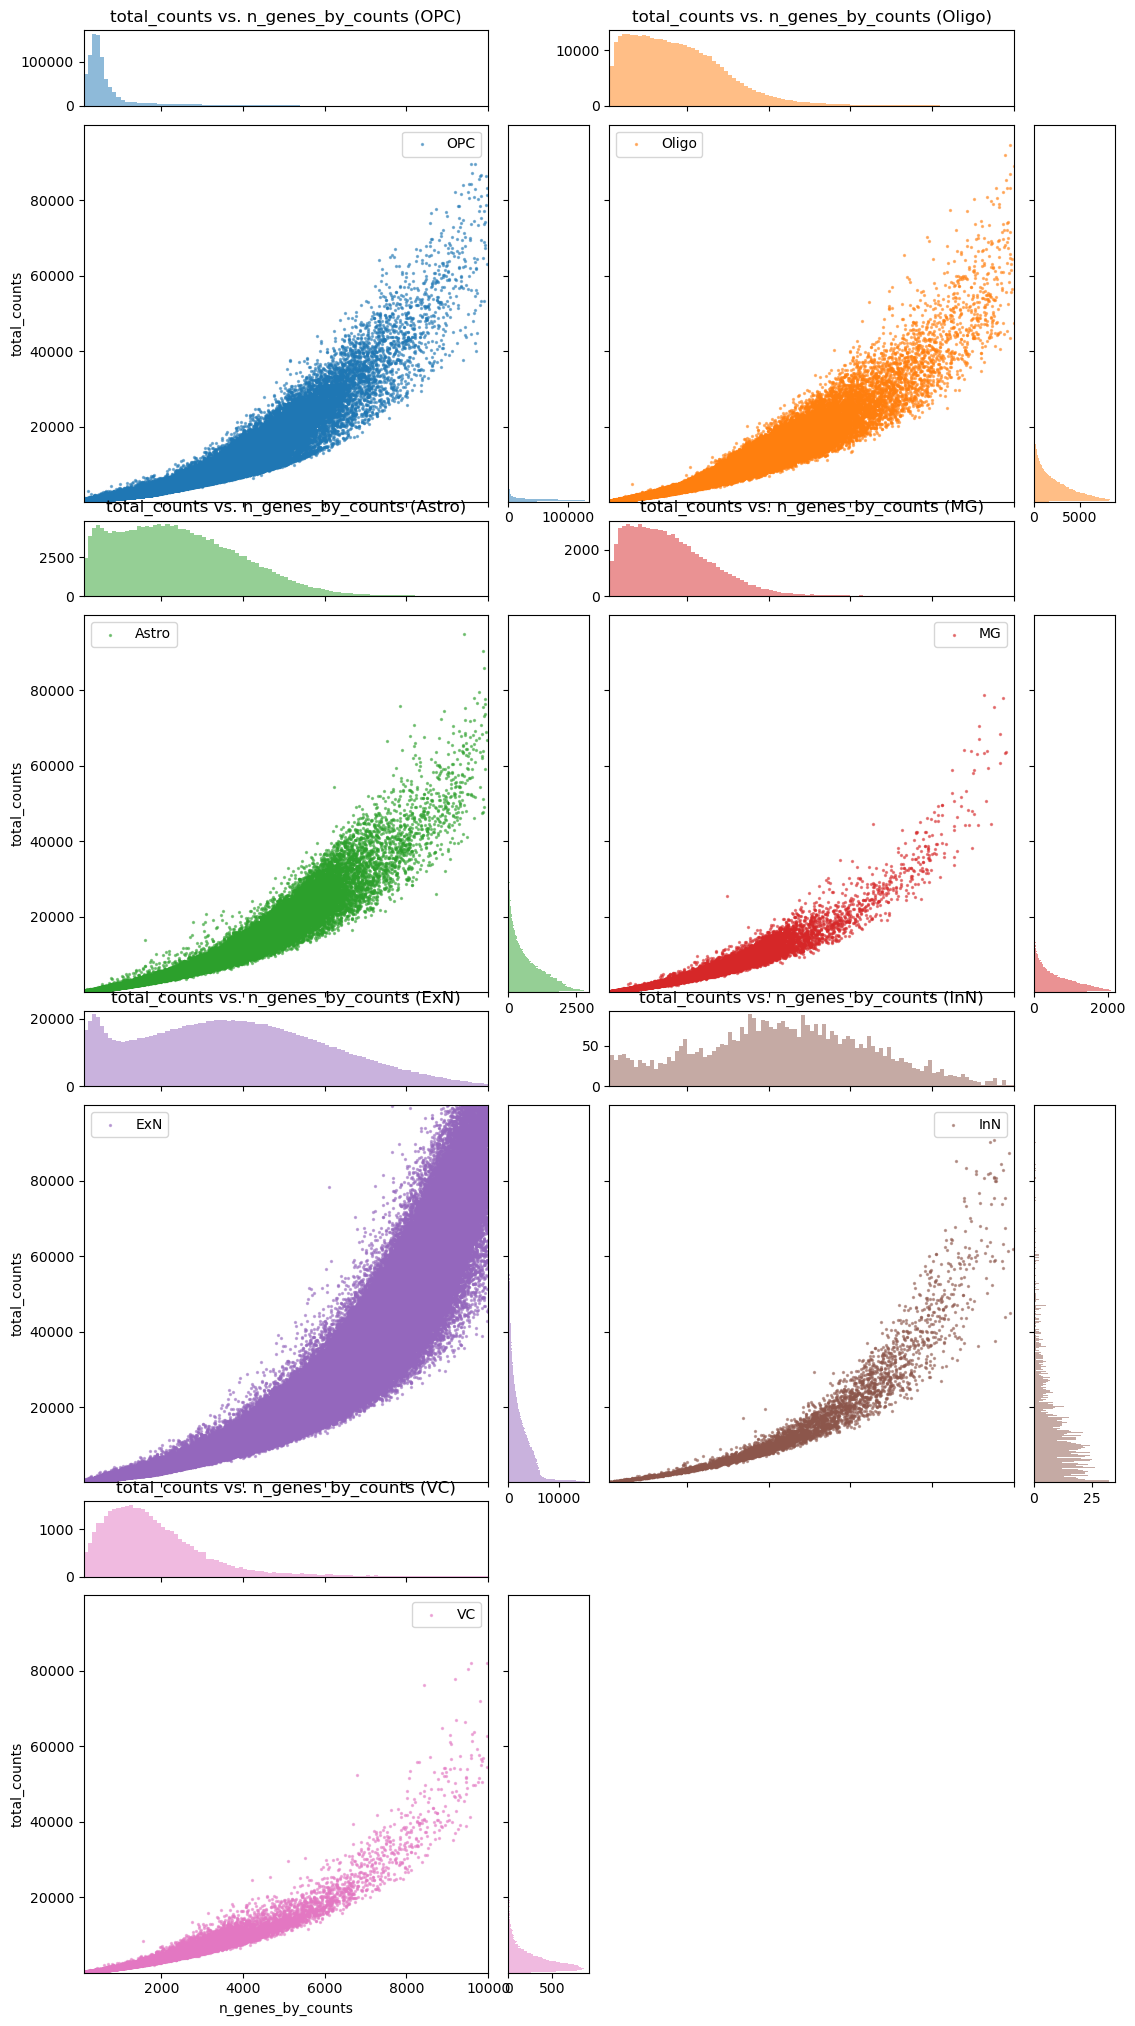

time: 11.3 s (started: 2025-03-05 21:02:35 -08:00)


In [18]:
ncols, nrows = 2, 4
cell_types = cell_metadata_df["cell_type"].unique()
num_cell_types = len(cell_types)

# Create subplots with space for marginal histograms
fig, axes = plt.subplots(
    nrows=nrows,
    ncols=ncols,
    figsize=(6 * ncols, 6 * nrows),
    gridspec_kw={"hspace": 0.3, "wspace": 0.3},
)

# Flatten axes array for easier iteration
axes = axes.flatten()

# Scatter plot for each cell type
x_min = cell_metadata_df["n_genes_by_counts"].min()
x_max = cell_metadata_df["n_genes_by_counts"].max()
y_min = cell_metadata_df["total_counts"].min()
y_max = cell_metadata_df["total_counts"].max()

for i, cell_type in enumerate(cell_types):
    df_cell_type = cell_metadata_df[cell_metadata_df["cell_type"] == cell_type]
    ax = axes[i]  # Use the corresponding subplot
    df_cell_type.plot.scatter(
        x="n_genes_by_counts",
        y="total_counts",
        color=plt.cm.tab10(i),
        label=cell_type,
        ax=ax,
        s=2,
        alpha=0.5,
    )

    # Add labels and title to each subplot
    ax.set_xlabel("n_genes_by_counts")
    ax.set_ylabel("total_counts")
    ax.set_title(f"total_counts vs. n_genes_by_counts ({cell_type})")

    # Set x and y limits for each subplot
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)

    # Create marginal histograms
    ax_histx = ax.inset_axes([0, 1.05, 1, 0.2], sharex=ax)  # Top
    ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)  # Right
    # # Create marginal histograms
    # ax_histx = ax.inset_axes([0, -0.3, 1, 0.2], sharex=ax)  # Bottom
    # ax_histy = ax.inset_axes([1.05, 0, 0.2, 1], sharey=ax)  # Right

    # Hide labels and ticks for marginal histograms
    ax_histx.tick_params(axis="x", labelbottom=False)
    ax_histy.tick_params(axis="y", labelleft=False)

    # # Plot histograms
    # ax_histx.hist(df_cell_type['n_genes_by_counts'], bins=20, color=plt.cm.tab10(i), alpha=0.5)
    # ax_histy.hist(df_cell_type['total_counts'], bins=20, color=plt.cm.tab10(i), alpha=0.5, orientation='horizontal')
    # Plot histograms with binwidth=100 and aligned limits
    ax_histx.hist(
        df_cell_type["n_genes_by_counts"],
        bins=range(int(x_min), int(x_max) + 100, 100),
        color=plt.cm.tab10(i),
        alpha=0.5,
    )
    ax_histy.hist(
        df_cell_type["total_counts"],
        bins=range(int(y_min), int(y_max) + 100, 100),
        color=plt.cm.tab10(i),
        alpha=0.5,
        orientation="horizontal",
    )
# Hide any unused subplots
for i in range(num_cell_types, len(axes)):
    axes[i].axis("off")

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()

### Dimensionality Reduction - UMAP

Let's have a look at the overall structure of the dataset by visualizing the [UMAP](https://umap-learn.readthedocs.io/en/latest/) 2D projection  of the data.  As the UMAP (or t-SNE) projections are somwehat arbitrary and don't preserve local OR global structure these are simply compact views at the data before further rigorous analysis.  E.g. ([link](https://pmc.ncbi.nlm.nih.gov/articles/PMC8195812/#:~:text=Despite%20their%20strengths%2C%20t%2DSNE,points%20in%20the%20source%20dataset), and [link](https://www.biorxiv.org/content/10.1101/2021.08.25.457696v1) )

The umaps here are constructed from the aproxamate nearest neighbor graph of the [scVI](https://docs.scvi-tools.org/en/stable/user_guide/models/scvi.html) latents fit to the overall dataset.

The UMAP and scVI components are stored in an [AnnData](https://anndata.readthedocs.io/en/latest/) object.  We'll use [scanpy](https://scanpy.readthedocs.io/en/stable/) to visualize these components with various metrics overlaid on them.

We can use the UMAP vectors from the cell-metadata table and [seaborn](https://seaborn.pydata.org/) to visualize some of the QC metrics in a 2D UMAP.

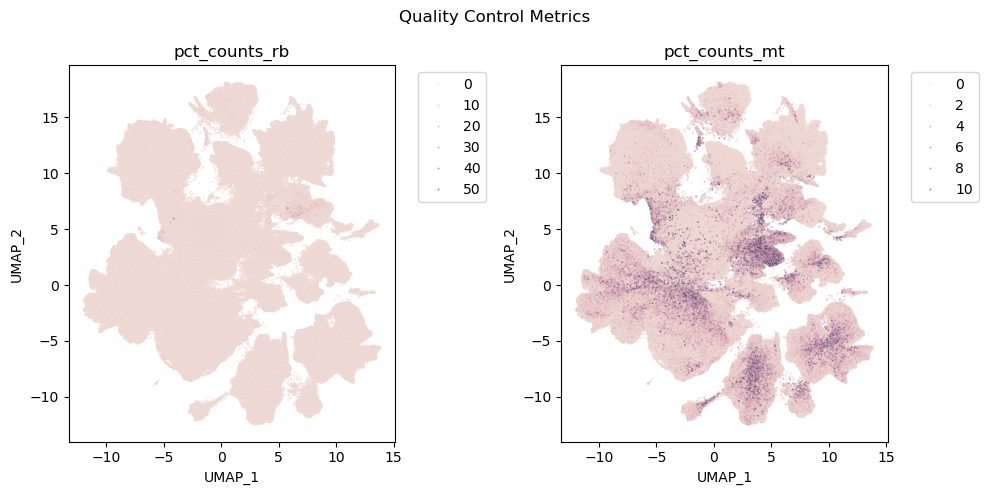

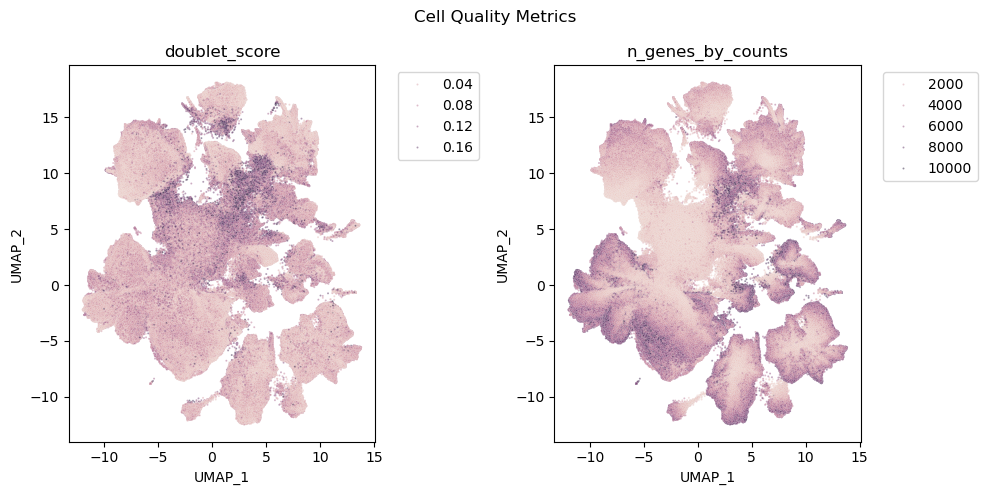

time: 2min 27s (started: 2025-03-05 21:02:46 -08:00)


In [19]:
# Define plot groups and their respective metadata columns
plot_groups = {
    "Quality Control Metrics": ["pct_counts_rb", "pct_counts_mt"],
    "Cell Quality Metrics": ["doublet_score", "n_genes_by_counts"],
    # 'Batch Information': ['batch', 'batch_id'],
    # 'Cell Phase and Type': ['phase', 'cell_type']
}


# Iterate over plot groups and create separate figures
for group_name, metadata_cols in plot_groups.items():
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))
    fig.suptitle(group_name)

    for i, metadata_col in enumerate(metadata_cols):
        sns.scatterplot(
            x="UMAP_1",
            y="UMAP_2",
            hue=metadata_col,
            data=cell_metadata_df,
            ax=axes[i],
            s=2,
            alpha=0.5,
        )
        axes[i].set_title(f"{metadata_col}")
        axes[i].set_xlabel("UMAP_1")
        axes[i].set_ylabel("UMAP_2")
        axes[i].legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    plt.tight_layout()
    plt.show()

## Copy dataset `anndata` to workspace 

Loading the dataset directly from the gcp bucket is inefficient.  Lets first copy it to our workspace files.

In [20]:
adata_filename = cohort_analysis_path / f"asap-{dataset_team}.final_adata.h5ad"
local_adata_filename = local_data_path / f"asap-{dataset_team}.final_adata.h5ad"

## REMOVE this.  its for local testing
local_adata_filename = adata_filename

time: 243 μs (started: 2025-03-05 21:05:14 -08:00)


In [21]:
if not local_adata_filename.exists():
    !cp {adata_filename} {local_adata_filename}


time: 18.4 ms (started: 2025-03-05 21:05:14 -08:00)


## Load `anndata` objects 
Now lets load the expression data object and use `scanpy` to do some visualizations.  Note this can take a while to load since its quite large dataset.

In [22]:
adata = sc.read_h5ad(local_adata_filename, backed="r")

adata

AnnData object with n_obs × n_vars = 2796736 × 3000 backed at '/home/ergonyc/workspace/01_PMDBS_scRNAseq_Datasets/asap-curated-cohort-pmdbs-sc-rnaseq/pmdbs_sc_rnaseq/cohort_analysis/asap-cohort.final_adata.h5ad'
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'cell_type'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden', 'log1p', 'neighbors', 'pca', 'scrublet', 'target_false_positive_rate', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_

time: 43.6 s (started: 2025-03-05 21:05:14 -08:00)


We can see that our `adata` object contains the cell-wise metadata in the `adata.obs` field, and gene-wise metadata in `adata.var`.  This `*.final_adata.h5ad` file contains only the top 3000 highly-variable genes.

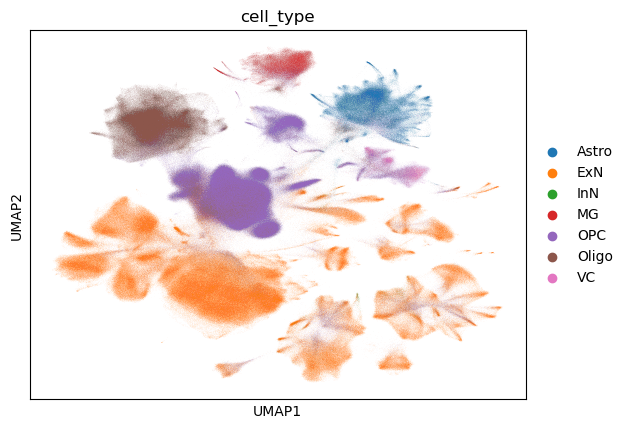

time: 7.55 s (started: 2025-03-05 21:05:58 -08:00)


In [23]:
# UMAP
sc.pl.embedding(adata, basis="umap", color=["cell_type"])

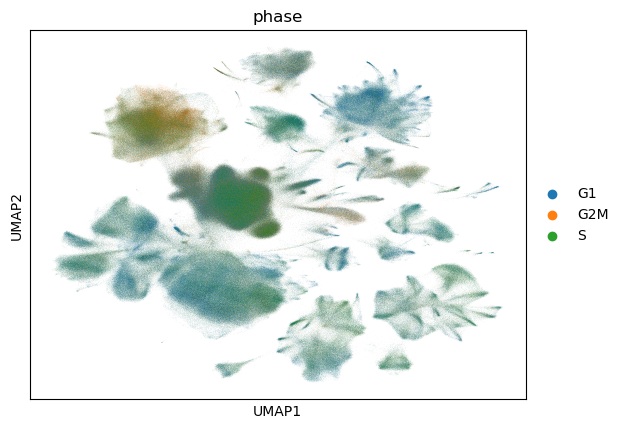

time: 7.5 s (started: 2025-03-05 21:06:05 -08:00)


In [24]:
# UMAP
sc.pl.embedding(adata, basis="umap", color=["phase"])

### Load _dataset_-metadata and merge with our _cell_-metadata
First lets load some of the _dataset_-metadata and map this information into our _cell_-metadata.
This will be used to annotate experimental conditions into our _cell_-level metadata.    In the next section we will use this to create subsets of our `asap-cohort` PMDBS snRNAseq dataset, and encode Parkinson's disease state.

Specifically we'll combine Sample-level, Subject-level, PMDBS specific  and experimental condition metadata, by combining the `SAMPLE`, `SUBJECT`, `PMDBS`, and `CONDITION` tables.


In [25]:
# Sample-level metadata
SAMPLE = pd.read_csv(ds_metadata_path / "SAMPLE.csv", index_col=0)
# subject-level metadata
SUBJECT = pd.read_csv(ds_metadata_path / "SUBJECT.csv", index_col=0)
#  brain-sample metadata
PMDBS = pd.read_csv(ds_metadata_path / "PMDBS.csv", index_col=0)
# experimental condition metadata
CONDITION = pd.read_csv(ds_metadata_path / "CONDITION.csv", index_col=0)

# Just take a few of the columns which we need
sample_cols = [
    "ASAP_sample_id",
    "ASAP_subject_id",
    "ASAP_team_id",
    "ASAP_dataset_id",
    "replicate",
    "condition_id",
]
subject_cols = [
    "ASAP_subject_id",
    "source_subject_id",
    "sex",
    "age_at_collection",
    "primary_diagnosis",
]
pmdbs_cols = [
    "ASAP_sample_id",
    "brain_region",
    "region_level_1",
    "region_level_2",
    "region_level_3",
]
condition_cols = [
    "condition_id",
    "intervention_name",
    "intervention_id",
    "protocol_id",
]

time: 5.93 ms (started: 2025-03-05 21:06:13 -08:00)


Now lets merge the teables into the metadata we are interested in, and create some dictionary "mappers" to encode each cell by their sample IDs.  

The _cell_-metadata sample is encoded as the `ASAP_sample_id` + `replicate`. 

In [26]:
df = pd.merge(
    SAMPLE[sample_cols], CONDITION[condition_cols], on="condition_id", how="left"
)
# then JOIN the result with SUBJECT on "ASAP_subject_id" how=left to get "age_at_collection", "sex", "primary_diagnosis"
df = pd.merge(df, SUBJECT[subject_cols], on="ASAP_subject_id", how="left")
# then JOIN the result with PMDBS on "ASAP_subject_id" how=left to get "brain_region"
df = pd.merge(df, PMDBS[pmdbs_cols], on="ASAP_sample_id", how="left")

# add a sample column
df["sample"] = df["ASAP_sample_id"] + "_" + df["replicate"]

time: 20.5 ms (started: 2025-03-05 21:06:13 -08:00)


Before we encode each cell's brain region identity, lets fix a few discrepancies in how the various contributions metadata were encoded. 

In [27]:
# recode brain region to be "PFC", "MFG", "HIP", "SN", "ACG", "IPL, "AMG", "PUT"
brain_fix = {
    "Prefrontal Cortex": "PFC",
    "Middle_Frontal_Gyrus": "MFG",
    "Hippocampus": "HIP",
    "Substantia_Nigra ": "SN",
    "Substantia_Nigra": "SN",
    "ACG": "ACG",
    "IPL": "IPL",
    "Middle temporal gyrus": "MTG",
    "Substantia nigra": "SN",
    "Prefrontal cortex": "PFC",
    "Amygdala": "AMG",
    "Putamen": "PUT",
}
df["brain_region"] = df["brain_region"].map(brain_fix)

time: 4.23 ms (started: 2025-03-05 21:06:13 -08:00)


In [28]:
# now map to find more course designations
brain_simple = {
    "PFC": "frontal_ctx",
    "MFG": "frontal_ctx",
    "ACG": "cingulate_ctx",
    "IPL": "parietal_ctx",
    "MTG": "temporal_ctx",
    "HIP": "subcortical",
    "AMG": "subcortical",
    "PUT": "subcortical",
    "SN": "subcortical",
}

df["brain_region_simple"] = df["brain_region"].map(brain_simple)


# define sample to match
br_mapper_full = dict(zip(df["sample"], df["brain_region"]))
br_mapper_simple = dict(zip(df["sample"], df["brain_region"].map(brain_simple)))

# Parkinsons and control samples
condition_id_mapper = dict(zip(df["sample"], df["condition_id"]))
case_id_mapper = dict(zip(df["sample"], df["intervention_id"]))

time: 7.65 ms (started: 2025-03-05 21:06:13 -08:00)


Lets save this _dataset_ metadata for later use in mapping the brain region and Case vs. Control to each cell in a frontal cortex sub-set of our cohort dataset.

In [29]:
dataset_metadata_filen = local_data_path / "asap-cohort-dataset-metadata.csv"
df.to_csv(dataset_metadata_filen)

time: 8.38 ms (started: 2025-03-05 21:06:13 -08:00)


In [30]:
dataset_metadata_filen

PosixPath('/home/ergonyc/workspace/workshop_files/asap-cohort-dataset-metadata.csv')

time: 7.01 ms (started: 2025-03-05 21:06:13 -08:00)


--------------



# Part 2: `AnnData` Data Composition 



The full `asap-cohort` PMDBS snRNAseq dataset contains gene expression (~36k genes) measurments of 2.7m cells.   We will subset to a smaller dataset of 290k prefrontal cortex cells.   

We will make this `AnnData` artifact available as the resources of loading the full dataset and subsetting can be.

An alternate strategy is to load each individual dataset individually, which is less resource intensive.  However, we would like to leverage the shared latent space for visualizations. 


Steps here.

* Load unfiltered dataset `AnnData` object
* combine with _processed_ artifacts (`adata.obs`) 
* Subset to a "frontal_ctx" brain region and Case-Contol group (from _dataset_ metadata)
    * save full gene expression `anndata` for subset with full metadata annotation (_dataset_ and _cell_-level)



We'll re-code the brain region metadata to make visualizations clearer (and also fix some coding discrepancies (e.g. SN), and create a `sample` id for mapping into the `adata.obs`.

Now map our new meta-data values into the `adata.obs`

### Subset by sample's brain region 

In the following we'll want to do a psuedo bulk differential expression analysis and also a simple meta-analysis over the individual contributions within the pan-ASAP CRN _cohort_ datasets.    Note that we are choosing to subset from the full asap-cohort so we can leverage the common UMAP.



In [31]:
# adata_filename = cohort_analysis_path / f"asap-{dataset_team}.final_adata.h5ad"
# adata = sc.read_h5ad(adata_filename, backed="r")

# add brain region to adata.obs
obs = adata.obs.copy()

obs["brain_region"] = obs["sample"].map(br_mapper_full)
obs["brain_region_simple"] = obs["sample"].map(br_mapper_simple)
obs["case_id"] = obs["sample"].map(case_id_mapper)

frontal_cells = obs["brain_region_simple"] == "frontal_ctx"

time: 199 ms (started: 2025-03-05 21:19:22 -08:00)


### Subset to "Case" or "Control" samples

Some of the contributed datasets include "Other" (e.g. 'prodromal PD') conditions besides "Ideopathic Parkinson's" and "Healthy Control".   We'll make a simplified dataset with just samples from Case (Parkinson's) and Control.  

In [32]:
case_control_cells = ~(obs["case_id"] == "Other")  # exclude "Other"

time: 77.6 ms (started: 2025-03-05 21:19:23 -08:00)


In [33]:
include = frontal_cells & case_control_cells

time: 1.33 ms (started: 2025-03-05 21:19:23 -08:00)



NOTE: We read the full 2.7m Cells X 36k genes from an h5ad file, NOT into memory.  Here we are copying the 291k cells into memory and closing the file.

In [34]:
frontal_ad = adata[include].to_memory()
adata.file.close()  # close the original adata file

time: 3.37 s (started: 2025-03-05 21:19:24 -08:00)


In [35]:
# add in any other metadata we'd like to use later?
frontal_ad.obs["case_control"] = frontal_ad.obs["sample"].map(case_id_mapper)
frontal_ad.obs["condition_id"] = frontal_ad.obs["sample"].map(condition_id_mapper)
frontal_ad.obs["case_id"] = frontal_ad.obs["sample"].map(case_id_mapper)
frontal_ad.obs["brain_region"] = frontal_ad.obs["sample"].map(br_mapper_simple)
frontal_ad

AnnData object with n_obs × n_vars = 291787 × 3000
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'cell_type', 'case_control', 'condition_id', 'case_id', 'brain_region'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden', 'log1p', 'neighbors', 'pca', 'scrublet', 'target_false_positive_rate', 'umap', 'cell_type_colors', 'phase_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_scvi', 'X_umap', '_scvi_extra_continuous_covs', 'gene_expression_e

time: 24.3 ms (started: 2025-03-05 21:19:29 -08:00)


Now we have a much smaller ~300k cells to work with, roughtly balanced btween Case and Control.

In [36]:
frontal_ad.obs["case_id"].value_counts()

case_id
Case       178065
Control    113722
Name: count, dtype: int64

time: 7.89 ms (started: 2025-03-05 21:19:30 -08:00)


Export subset for merging with full gene expression to our `local_data_path`.

In [37]:
frontal_samples_filename = (
    local_data_path / f"asap-{dataset_team}.frontal_ctx_case_control_samples.h5ad"
)
frontal_ad.write_h5ad(frontal_samples_filename)

time: 1.64 s (started: 2025-03-05 21:19:33 -08:00)


Although we've subset to a much smaller dataset, we can see in our UMAP visualization that we have a wide ssampling of the overall gene expression latent space. 

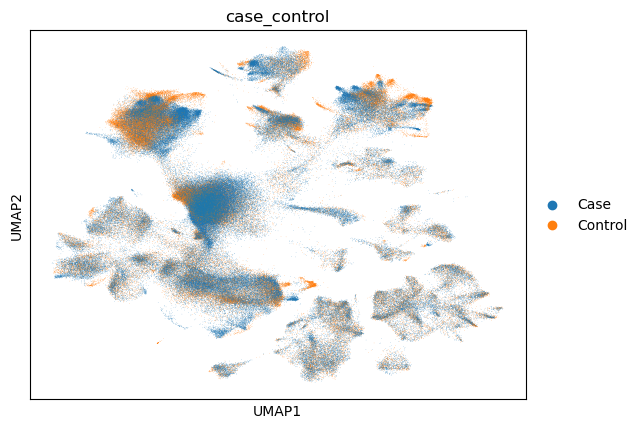

time: 819 ms (started: 2025-03-05 21:19:37 -08:00)


In [38]:
sc.pl.embedding(frontal_ad, basis="umap", color=["case_control"])

In [39]:
del adata, frontal_ad

time: 128 μs (started: 2025-03-05 21:19:38 -08:00)


## Compose subset `AnnData` summary object 

### Copy dataset `anndata` to workspace 

Loading the dataset directly from the gcp bucket is inefficient.  Lets first copy it to our workspace files.

In [40]:
full_adata_filename = (
    cohort_analysis_path / f"asap-{dataset_team}.merged_adata_object.h5ad"
)
l_full_adata_filename = (
    local_data_path / f"asap-{dataset_team}.merged_adata_object.h5ad"
)

time: 227 μs (started: 2025-03-05 21:19:41 -08:00)


In [41]:
if not l_full_adata_filename.exists():
    !cp {full_adata_filename} {l_full_adata_filename}

time: 23.4 s (started: 2025-03-05 21:19:42 -08:00)


### Load _full_ gene expression 
 
We'll construct an adata having the full (not limited to highly variable genes) gene expression, by combining the the subset adata (with all the embeddings and analyses) with the `asap-cohort.merged_adata_object.h5ad`.

In [42]:
full_adata = sc.read_h5ad(l_full_adata_filename, backed="r")

frontal_samples_filename = (
    local_data_path / f"asap-{dataset_team}.frontal_ctx_case_control_samples.h5ad"
)
frontal_ad = sc.read_h5ad(frontal_samples_filename, backed="r")

var_ = full_adata.var.copy()
X = full_adata[frontal_ad.obs_names].X.copy()

full_adata.file.close()

time: 36.7 s (started: 2025-03-05 21:20:05 -08:00)


Now we can combine the _full_ gene expression matrix wit ouyr frontal cortex subset, and save the resulting `AnnData`object.

In [43]:
frontal_full_ad = sc.AnnData(
    X=X,
    obs=frontal_ad.obs,
    var=var_,
    uns=frontal_ad.uns,
    obsm=frontal_ad.obsm,
)

time: 19 ms (started: 2025-03-05 21:20:42 -08:00)


### Export full frontal cortex `AnnData` object for further analysis

In [44]:
frontal_full_samples_filename = (
    local_data_path / f"asap-{dataset_team}.full_frontal_ctx_case_control_samples.h5ad"
)
frontal_full_ad.write_h5ad(frontal_full_samples_filename)

time: 3.88 s (started: 2025-03-05 21:20:42 -08:00)


-----------------



#  Part 3: Gene of interest analysis (__Workshop__)

* Gene of interest analysis
    * Choose Parkinson's Disease relavent gene
    * Load transciptomics counts data into an anndata object
        * subset cells to subset samples from metadata
    * visualize specific gene expression

## choose your favorite genes
Now that we have a 
1. check that your gene of interest is in the current features
2. color the umap by the expression level of your gene.


We'll use the soon-to-be-published table from GP2 as a reference for PD variable genes.



### Load Parkinson's reference genes.

In [47]:
ref_gene_filename = WORKSHOP_PATH / "GP2 European GWAS Manuscript Tables - Table 4.csv"

GP2_PD_genes = pd.read_csv(ref_gene_filename)

time: 1.72 ms (started: 2025-03-05 21:22:03 -08:00)


### Load full frontal cortex `AnnData` object for further analysis 

If you calculated these yourself in [Part 2](add link to notebook) load if from where you saved it. (e.g. 'local_data_path').  We have also made it available in the `WORKSHOP_PATH` 

In [48]:
full_frontal_samples_filename = (
    local_data_path / f"asap-{dataset_team}.full_frontal_ctx_case_control_samples.h5ad"
)

frontal_full_ad = sc.read_h5ad(full_frontal_samples_filename)

time: 2.8 s (started: 2025-03-05 21:22:08 -08:00)


Check that we have the genes of interest.

In [49]:
query_genes = set(GP2_PD_genes["SYMBOL"]).intersection(set(frontal_full_ad.var_names))

time: 2.11 ms (started: 2025-03-05 21:22:11 -08:00)


In [50]:
query_genes

{'ADAM15',
 'ADD1',
 'AKT3',
 'BAG3',
 'BIRC6',
 'CAB39L',
 'CPLX1',
 'CTSB',
 'DLG2',
 'DLG4',
 'FDFT1',
 'FYN',
 'GAK',
 'GCH1',
 'ITGA2B',
 'LRRK2',
 'MAPT',
 'MED12L',
 'NCOR1',
 'P2RY12',
 'PCGF3',
 'PIK3CA',
 'RIT2',
 'SH3GL2',
 'SHC1',
 'SLC2A13',
 'SNCA',
 'STK39',
 'TMEM163',
 'TSC22D4',
 'UCHL1',
 'XPO1'}

time: 22.7 ms (started: 2025-03-05 21:22:11 -08:00)


### Choose 'query_gene' and visualize

In [53]:
query_gene = "CTSB"
query_gene = "TSC22D4"


CTSB_expr = frontal_full_ad[:, query_gene].X.toarray()
cell_metadata_df = pd.DataFrame(
    CTSB_expr, columns=[query_gene], index=frontal_full_ad.obs.index
)

cell_metadata_df.loc[:, "cell_type"] = frontal_full_ad.obs["cell_type"]

cell_metadata_df.groupby("cell_type").describe()

/tmp/ipykernel_1356486/3696347351.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.


TSC22D4                                              
              count      mean       std  min  25%  50%  75%   max
cell_type                                                        
Astro       22347.0  0.804135  1.142683  0.0  0.0  0.0  1.0  13.0
ExN        126083.0  0.050491  0.254753  0.0  0.0  0.0  0.0   9.0
InN           726.0  0.088154  0.345130  0.0  0.0  0.0  0.0   3.0
MG           8090.0  0.143263  0.413781  0.0  0.0  0.0  0.0   5.0
OPC         76552.0  0.133961  0.566849  0.0  0.0  0.0  0.0  16.0
Oligo       55627.0  0.972028  1.449174  0.0  0.0  0.0  1.0  18.0
VC           2362.0  0.230737  0.657685  0.0  0.0  0.0  0.0   8.0

time: 417 ms (started: 2025-03-05 21:23:31 -08:00)


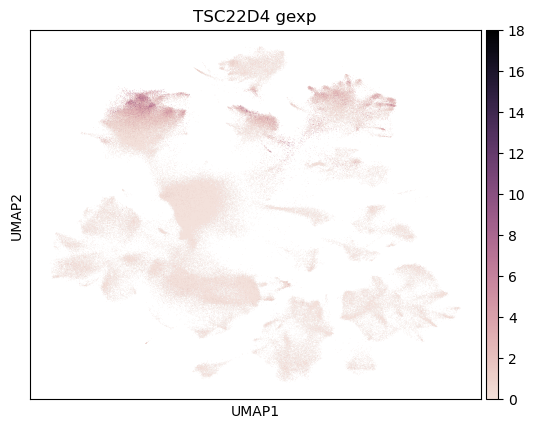

time: 1.08 s (started: 2025-03-05 21:23:42 -08:00)


In [54]:
sc.pl.embedding(
    frontal_full_ad,
    basis="umap",
    color=[query_gene],
    cmap=sns.cubehelix_palette(dark=0, light=0.9, as_cmap=True),
    title=f"{query_gene} gexp",
)

----------------------



# Part 4: Differential Expression (DE) Analysis (__Advanced__)

* Differential expression analysis
* Differential expression analysis meta-analysis

Here we'll run through a simple differential analysis of gene expression aimed at finding which genes are over/under-expressed in Frontal Cortex derived PMDBS for Parkinson's patient brains versus Controls. 

We'll do psuedo-bulking by simply summing all cells derived from the same _sample_ having the same "cell_type".   

Caveat:  Cell-typing.   Our gene-expression phenotype ("cell_type") have been inferred for a simple taxonomy leveraging by a very naive set of marker genes with `CellAssign`.   A more powerful procedure for infering ground-truth gene-expression phenotype, would enhance the utility of this analysis.


In [55]:
adata = frontal_full_ad
adata

AnnData object with n_obs × n_vars = 291787 × 36601
    obs: 'background_fraction', 'cell_probability', 'cell_size', 'droplet_efficiency', 'n_genes_by_counts', 'total_counts', 'total_counts_rb', 'pct_counts_rb', 'total_counts_mt', 'pct_counts_mt', 'doublet_score', 'sample', 'batch', 'team', 'dataset', 'batch_id', 'S_score', 'G2M_score', 'phase', '_scvi_batch', '_scvi_labels', 'leiden_res_0.05', 'leiden_res_0.10', 'leiden_res_0.20', 'leiden_res_0.40', 'cell_type', 'case_control', 'condition_id', 'case_id', 'brain_region'
    var: 'feature_type', 'genome', 'gene_id', 'mt', 'rb'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'estimator', 'fraction_data_used_for_testing', 'learning_curve_learning_rate_epoch', 'learning_curve_test_epoch', 'learning_curve_train_epoch', 'leiden', 'log1p', 'neighbors', 'pca', 'phase_colors', 'scrublet', 'target_false_positive_rate', 'umap'
    obsm: 'X_pca', 'X_pca_harmony', 'X_scvi', 'X_umap', '_scvi_extra_continuous_covs', 'gene_expression_

time: 9.09 ms (started: 2025-03-05 21:24:01 -08:00)


full_frontal_samples_filename = (
    local_data_path / f"asap-{dataset_team}.full_frontal_ctx_case_control_samples.h5ad"
)
adata = sc.read_h5ad(full_frontal_samples_filename)


## Construct Simple Psuedobulk

We'll create a _simple_ psuedobulk dataset by summing counts over cells from individual samples for each cell_type. 

> Note: it might be more elegant to use the `decoupler` framework to construct psuedobulk gene-expression, but the goal here was simply to demonstrate the logic.

In [56]:
# create pseudo-bulk expression matrix
gene_ids = adata.var["gene_id"]
pbs = []
for cell_type in adata.obs["cell_type"].unique():
    cell_type_adata = adata[adata.obs["cell_type"] == cell_type]

    for sample in cell_type_adata.obs["sample"].unique():
        samp_cell_subset = cell_type_adata[cell_type_adata.obs["sample"] == sample]
        X = samp_cell_subset.X.toarray()
        rep_adata = sc.AnnData(
            X=X.sum(axis=0).reshape(1, -1),
            var=samp_cell_subset.var[[]],
        )
        rep_adata.obs_names = [cell_type + "_" + sample]
        rep_adata.obs["dataset"] = samp_cell_subset.obs["dataset"].iloc[0]
        rep_adata.obs["cell_type"] = samp_cell_subset.obs["cell_type"].iloc[0]
        rep_adata.obs["case_control"] = samp_cell_subset.obs["case_control"].iloc[0]

        pbs.append(rep_adata)


pb = sc.concat(pbs)

pb.var["gene_name"] = pb.var.index
pb.var_names = gene_ids
pb

AnnData object with n_obs × n_vars = 399 × 36601
    obs: 'dataset', 'cell_type', 'case_control'
    var: 'gene_name'

time: 17 s (started: 2025-03-05 21:24:05 -08:00)


In [57]:
psuedobulk_cortical_samples_filename = (
    local_data_path / f"asap-{dataset_team}.full_frontal_ctx_psuedobulk.h5ad"
)
pb.write_h5ad(psuedobulk_cortical_samples_filename)

time: 71 ms (started: 2025-03-05 21:24:22 -08:00)


## Differential Expression

We will perform a super simple differential expression calculation by logistic regression for the log zscored samples for each gene on Case vs. Control.   

If you want to start from here simply load the psuedobulk anndata created above.


In [58]:
reload = False

if reload:
    psuedobulk_cortical_samples_filename = (
        local_data_path / f"asap-{dataset_team}.full_frontal_ctx_psuedobulk.h5ad"
    )

    pb = sc.read_h5ad(psuedobulk_cortical_samples_filename)

time: 221 μs (started: 2025-03-05 21:24:22 -08:00)


### calculate differential expression

We'll take the log of the psuedobulks and zscore with `scanpy` to normalize the expression for each gene psuedobulk.  In this initial analysis we'll zscore and regress all the cells per `cell_type`.
This takes about 20 minutes.

In [ ]:
# use logger and ignore warnings so this doesn't swamp the notebook with output
logger = logging.getLogger()
fhandler = logging.FileHandler(filename="nb_log.log", mode="w")
logger.addHandler(fhandler)
logging.warning("This is a warning message")

warnings.filterwarnings("ignore")  #

# Initialize a DataFrame to store results for this subdirectory
# Step 3: Loop over cell types and perform logistic regression
regression_count = 0
results = pd.DataFrame(columns=["CELL_TYPE", "ENSG", "BETA", "SE", "P", "N"])

for cell_type in pb.obs["cell_type"].unique():
    cell_type_pb = pb[pb.obs["cell_type"] == cell_type].copy()
    logging.info(f" {cell_type=}, {cell_type_pb.shape=}")

    # Step 4: Apply log-transform and z-scaling for each cell_type
    sc.pp.log1p(cell_type_pb)
    sc.pp.scale(cell_type_pb)

    # X = cell_type_pb.X.toarray()
    # log_transformed = np.log1p(X)
    # z_scaled = (log_transformed - log_transformed.mean()) / log_transformed.std(ddof=0)

    # Step 5: Perform logistic regression for each gene
    # Iterate over ENSG prefixed columns
    for ensg in cell_type_pb.var_names:
        regression_count += 1
        try:
            data = cell_type_pb.obs[["case_control"]]
            data = (cell_type_pb.obs[["case_control"]] != "Control").astype(int)
            data[ensg] = cell_type_pb[:, ensg].X.toarray()
            # Perform logistic regression
            formula = f"case_control ~ {ensg}"
            model = smf.logit(formula, data=data).fit(disp=False)

            # Extract results
            beta = model.params[ensg]
            se = model.bse[ensg]
            p_value = model.pvalues[ensg]
            n = model.nobs

            # Create a new row of results
            new_row = pd.DataFrame(
                [
                    {
                        "CELL_TYPE": cell_type,
                        "ENSG": ensg,
                        "BETA": beta,
                        "SE": se,
                        "P": p_value,
                        "N": n,
                    }
                ]
            )
            # Append to results table
            results = pd.concat([results, new_row], ignore_index=True)

            # Print only every 1000th model
            if regression_count % 1000 == 0:
                msg = f"\nRegression {regression_count} in {cell_type}:"
                msg += f"\nFormula: {formula}"
                msg += f"\n{model.summary()}"
                logging.info(msg)

        except Exception as e:
            # print(f"Error analyzing  {cell_type}, {ensg}: {e}")
            logging.error(f"Error analyzing  {cell_type}, {ensg}: {e}")


simple_de_filenm = (
    local_data_path / f"asap-{dataset_team}.full_frontal_ctx_psuedobulk_de.csv"
)

results.to_csv(simple_de_filenm, index=False)

### Visualize DE Results

Below is a function to make a simple volcano plot.

In [60]:
def simple_volcano(results: pd.DataFrame, ensg_to_gene: pd.DataFrame):
    # Create a new column for -log10(p)
    results["minus_log10_p"] = -np.log10(results["P"])
    df = results.copy()
    # Ignore rows where BETA > |3|
    df = df[df["BETA"].abs() <= 3]

    df = df.merge(ensg_to_gene, left_on="ENSG", right_index=True, how="left")

    # For each cell type, find the gene with the highest -log10 p-value
    top_hits = df.loc[df.groupby("CELL_TYPE")["minus_log10_p"].idxmax()]

    plt.figure(figsize=(10, 6))
    # Use seaborn to plot with CELL_TYPE as hue and N to adjust marker sizes
    sns.scatterplot(data=df, x="BETA", y="minus_log10_p", hue="CELL_TYPE", alpha=0.7)

    # Annotate the top 10 genes on the plot
    for _, row in top_hits.iterrows():
        # You can adjust the text offset (e.g., using ha, va, or adding a small offset to x/y)
        plt.text(
            row["BETA"],
            row["minus_log10_p"],
            row["gene_name"],
            fontsize=9,
            ha="right",
            va="bottom",
        )

    # Add a horizontal line for p=0.05 (optional threshold)
    plt.axhline(-np.log10(0.05), color="red", linestyle="--", linewidth=1)

    plt.xlabel("Beta Coefficient")
    plt.ylabel("-log10(P-value)")
    plt.title("Volcano Plot of Differential Expression")
    plt.show()
    return top_hits

time: 765 μs (started: 2025-03-05 21:25:04 -08:00)


/home/ergonyc/mambaforge/envs/nb_env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10


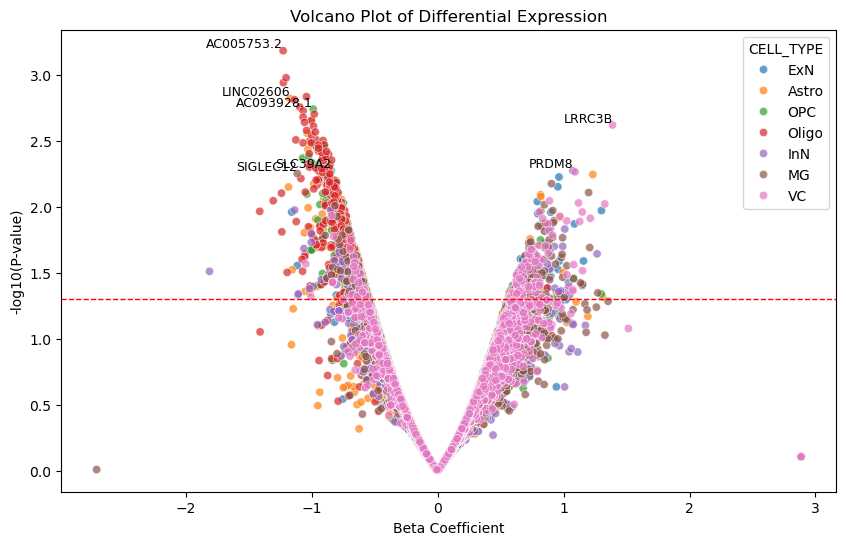

,CELL_TYPE,ENSG,BETA,SE,P,N,minus_log10_p,gene_name
35406,Astro,ENSG00000284693,-1.170897,0.369378,0.001525,59,2.816779,LINC02606
23049,ExN,ENSG00000165794,-0.844171,0.303143,0.005357,59,2.271058,SLC39A2
140534,InN,ENSG00000152784,1.074436,0.385836,0.005358,47,2.271013,PRDM8
186889,MG,ENSG00000254521,-1.114150,0.402272,0.005612,59,2.250895,SIGLEC12
73994,OPC,ENSG00000286952,-0.986917,0.316656,0.001829,59,2.737799,AC093928.1
110959,Oligo,ENSG00000286736,-1.225868,0.359963,0.000660,59,3.180237,AC005753.2
194547,VC,ENSG00000179796,1.388837,0.457715,0.002411,57,2.617786,LRRC3B


time: 2.35 s (started: 2025-03-05 21:27:12 -08:00)


In [63]:
simple_de_filenm = (
    local_data_path / f"asap-{dataset_team}.full_frontal_ctx_psuedobulk_de.csv"
)

results = pd.read_csv(simple_de_filenm)

top_hits_by_cell_type = simple_volcano(results, pb.var.copy())
top_hits_by_cell_type

## DE meta analysis 

This meta analysis tests the robustness of the DE across individual contributions in our 'asap-cohort' dataset.


### calculate differential expression

In the previous section we calculated the Case/Control DE for each cell_type with logistic regression on the log zscores of our psuedobulks.   Now we need to recalculate the DE for each cell_type for each dataset. 

In [ ]:
results_by_dataset = {}

for dataset in pb.obs["dataset"].unique():
    dataset_adata = pb[pb.obs["dataset"] == dataset]
    results = pd.DataFrame(
        columns=["DATASET", "CELL_TYPE", "ENSG", "BETA", "SE", "P", "N"]
    )

    regression_count = 0
    for cell_type in dataset_adata.obs["cell_type"].unique():
        cell_type_pb = dataset_adata[dataset_adata.obs["cell_type"] == cell_type].copy()
        print(cell_type, cell_type_pb.shape)

        # Step 4: Apply log-transform and z-scaling for each cell_type
        sc.pp.log1p(cell_type_pb)
        sc.pp.scale(cell_type_pb)

        # X = cell_type_pb.X.toarray()
        # log_transformed = np.log1p(X)
        # z_scaled = (log_transformed - log_transformed.mean()) / log_transformed.std(ddof=0)

        # Step 5: Perform logistic regression for each gene
        # Iterate over ENSG prefixed columns
        for ensg in cell_type_pb.var_names:
            regression_count += 1
            try:

                data = cell_type_pb.obs[["case_control"]]
                data = (cell_type_pb.obs[["case_control"]] != "Control").astype(int)
                data[ensg] = cell_type_pb[:, ensg].X.toarray()
                # Perform logistic regression
                formula = f"case_control ~ {ensg}"
                model = smf.logit(formula, data=data).fit(disp=False)

                # Extract results
                beta = model.params[ensg]
                se = model.bse[ensg]
                p_value = model.pvalues[ensg]
                n = model.nobs

                # Create a new row of results
                new_row = pd.DataFrame(
                    [
                        {
                            "DATASET": dataset,
                            "CELL_TYPE": cell_type,
                            "ENSG": ensg,
                            "BETA": beta,
                            "SE": se,
                            "P": p_value,
                            "N": n,
                        }
                    ]
                )
                # Append to results table
                results = pd.concat([results, new_row], ignore_index=True)

                # Print only every 1000th model
                if regression_count % 1000 == 0:
                    msg = f"\nRegression {regression_count} in {cell_type}:"
                    msg += f"\nFormula: {formula}"
                    msg += f"\n{model.summary()}"
                    logging.info(msg)

            except Exception as e:
                # print(f"Error analyzing  {cell_type}, {ensg}: {e}")
                logging.error(f"Error analyzing  {cell_type}, {ensg}: {e}")

    results_by_dataset[dataset] = results

    # Step 4: Export results for this subdirectory with a timestamp
    dataset_de_filenm = (
        local_data_path
        / f"asap-{dataset_team}.full_frontal_ctx_psuedobulk_de.meta_analysis_{dataset}.csv"
    )

    results.to_csv(dataset_de_filenm, index=False)

In [ ]:
all_data_df = pd.concat(results_by_dataset, ignore_index=True)

In [ ]:
all_data_df

###  Fixed effect and random-effect meta-analysis

These are the functions below that power the meta-analyses.


In [64]:
# Function to calculate fixed effect meta-analysis
def fixed_effect_meta_analysis(betas, ses):
    weights = 1 / (ses**2)
    beta_fe = np.sum(weights * betas) / np.sum(weights)
    se_fe = np.sqrt(1 / np.sum(weights))
    z_fe = beta_fe / se_fe
    p_fe = 2 * norm.sf(abs(z_fe))
    return beta_fe, se_fe, p_fe


# Function to calculate random effect meta-analysis
def random_effect_meta_analysis(betas, ses):
    weights = 1 / (ses**2)
    beta_fe, se_fe, _ = fixed_effect_meta_analysis(betas, ses)
    q_stat = np.sum(weights * ((betas - beta_fe) ** 2))
    df = len(betas) - 1
    tau2 = max(
        0, (q_stat - df) / (np.sum(weights) - np.sum(weights**2) / np.sum(weights))
    )
    weights_re = 1 / (ses**2 + tau2)
    beta_re = np.sum(weights_re * betas) / np.sum(weights_re)
    se_re = np.sqrt(1 / np.sum(weights_re))
    z_re = beta_re / se_re
    p_re = 2 * norm.sf(abs(z_re))
    i2 = max(0, ((q_stat - df) / q_stat) * 100 if q_stat > df else 0)
    return beta_re, se_re, p_re, i2

time: 536 μs (started: 2025-03-05 21:27:45 -08:00)


Note the code below deletes results whihc have a BETA value > |3|. A BETA value this large is indicative of poor model fit.
Also note, this is a strict FDR, correcting for all tests done across cell types.

In [65]:
dataset_de_filenms = local_data_path.glob(
    f"asap-{dataset_team}.full_frontal_ctx_psuedobulk_de.meta_analysis_*.csv"
)
for file in dataset_de_filenms:
    print(file)

/home/ergonyc/workspace/workshop_files/asap-cohort.full_frontal_ctx_psuedobulk_de.meta_analysis_DS_PMDBS_0002.csv
/home/ergonyc/workspace/workshop_files/asap-cohort.full_frontal_ctx_psuedobulk_de.meta_analysis_DS_PMDBS_0001.csv
/home/ergonyc/workspace/workshop_files/asap-cohort.full_frontal_ctx_psuedobulk_de.meta_analysis_DS_PMDBS_0004.csv
time: 1.03 ms (started: 2025-03-05 21:27:53 -08:00)


In [66]:
data_loaded = False

if not data_loaded:
    #  Pull the trigger and meta-analyze
    all_data = []
    dataset_de_filenms = local_data_path.glob(
        f"asap-{dataset_team}.full_frontal_ctx_psuedobulk_de.meta_analysis_*.csv"
    )
    for file in dataset_de_filenms:
        df = pd.read_csv(file)
        # Ignore rows where BETA > |3|
        df = df[df["BETA"].abs() <= 3]
        df["FILE"] = file.name
        all_data.append(df)

    # Combine all data
    all_data_df = pd.concat(all_data, ignore_index=True)

else:
    print("Data already loaded")
    # add a FILE column to the dataframe
    all_data_df["FILE"] = all_data_df["DATASET"].apply(
        lambda x: f"asap-{dataset_team}.full_frontal_ctx_psuedobulk_de.meta_analysis_{x}.csv"
    )
    # Ignore rows where BETA > |3|
    all_data_df = all_data_df[all_data_df["BETA"].abs() <= 3]

time: 307 ms (started: 2025-03-05 21:28:03 -08:00)


In [67]:
cell_type

'VC'

time: 1.31 ms (started: 2025-03-05 21:28:05 -08:00)


In [68]:
# Group by CELL_TYPE and ENSG
meta_analysis_results = []
for (cell_type, ensg), group in all_data_df.groupby(["CELL_TYPE", "ENSG"]):
    if group["FILE"].nunique() < 2:
        continue  # Skip combinations not present in at least two results files

    betas = group["BETA"].values
    ses = group["SE"].values

    # Perform fixed effect meta-analysis
    beta_fe, se_fe, p_fe = fixed_effect_meta_analysis(betas, ses)

    # Perform random effect meta-analysis
    beta_re, se_re, p_re, i2 = random_effect_meta_analysis(betas, ses)

    # Collect results
    meta_analysis_results.append(
        {
            "CELL_TYPE": cell_type,
            "ENSG": ensg,
            "BETA_FE": beta_fe,
            "SE_FE": se_fe,
            "P_FE": p_fe,
            "BETA_RE": beta_re,
            "SE_RE": se_re,
            "P_RE": p_re,
            "I2": i2,
        }
    )

time: 46.7 s (started: 2025-03-05 21:30:01 -08:00)


In [69]:
# Convert results to DataFrame
results_df = pd.DataFrame(meta_analysis_results)

# Apply FDR correction
results_df["P_FE_FDR"] = multipletests(results_df["P_FE"], method="fdr_bh")[1]
results_df["P_RE_FDR"] = multipletests(results_df["P_RE"], method="fdr_bh")[1]

# Save results to CSV
timestamp = pd.Timestamp.now().strftime("%Y%m%d")
timestamp = "2025-02-24"

output_file = local_data_path / f"meta_analysis_results_{timestamp}.csv"
results_df.to_csv(output_file, index=False)

print(f"Meta-analysis results saved to {output_file}")

Meta-analysis results saved to /home/ergonyc/workspace/workshop_files/meta_analysis_results_2025-02-24.csv
time: 880 ms (started: 2025-03-05 21:30:48 -08:00)


In [70]:
results_df["CELL_TYPE"].unique()

array(['Astro', 'ExN', 'InN', 'MG', 'OPC', 'Oligo', 'VC'], dtype=object)

time: 4.12 ms (started: 2025-03-05 21:30:49 -08:00)


### Summarize results

Lets see which genes are significant.   We'll also add gene-names for easy interrogation.

In [71]:
# Filter the rows where either P_FE_FDR or P_RE_FDR is significant (less than 0.05)
significant_rows = results_df[
    (results_df["P_FE_FDR"] < 0.05) | (results_df["P_RE_FDR"] < 0.05)
]
# Print the significant rows to the screen
print(significant_rows)

Empty DataFrame
Columns: [CELL_TYPE, ENSG, BETA_FE, SE_FE, P_FE, BETA_RE, SE_RE, P_RE, I2, P_FE_FDR, P_RE_FDR]
Index: []
time: 17.6 ms (started: 2025-03-05 21:30:49 -08:00)


In [72]:
significant_rows = significant_rows.merge(
    pb.var, left_on="ENSG", right_index=True, how="left"
)
significant_rows

,CELL_TYPE,ENSG,BETA_FE,SE_FE,P_FE,BETA_RE,SE_RE,P_RE,I2,P_FE_FDR,P_RE_FDR,gene_name


time: 11.3 ms (started: 2025-03-05 21:30:49 -08:00)


In [73]:
significant_rows["gene_name"]

Series([], Name: gene_name, dtype: object)

time: 3.69 ms (started: 2025-03-05 21:30:49 -08:00)


Nothing was consistent across the contributions with this analysis!  Null result.

-----------------
# Finished!!!

Well done!  Now you are ready to to leverage the ASAP CRN Cloud datasets!

--------


In [ ]:
# ## Quick annotate the gene symbiols for easy use by others.
# ! pip install mygene

# import mygene

# # Initialize mygene
# mg = mygene.MyGeneInfo()

# ensg_ids = significant_rows["ensmbl_ID"].tolist()
# annotations = mg.querymany(
#     ensg_ids, scopes="ensembl.gene", fields="symbol", species="human"
# )

# # Create a mapping of ENSG IDs to gene symbols
# annotation_dict = {entry["query"]: entry.get("symbol", None) for entry in annotations}

# # Add a new column with gene symbols to the DataFrame
# significant_rows["Gene_Symbol"] = significant_rows["ensmbl_ID"].map(annotation_dict)

# significant_rows

--------------------
# Provenance
Generate information about this notebook environment and the packages installed.

In [ ]:
!date

Conda and pip installed packages:

In [ ]:
!conda env export

JupyterLab extensions:

In [ ]:
!jupyter labextension list

Number of cores:

In [ ]:
!grep ^processor /proc/cpuinfo | wc -l

Memory:

In [ ]:
!grep "^MemTotal:" /proc/meminfo